# Jonathan Halverson
# Wednesday, December 27, 2017
# Simple autoencoder

The idea here is to use an autoencoder as a method of dimensionality reduction. We use an undercomplete linear autoencoder which means the coding layer has fewer features than than the inputs (and inputs equals number of outputs, of course). In general autoencoders are ANN capable of learning efficient representations of the inputs. They essentially learn to copy their inputs to their outputs under some constraint. The constraints prevent the autoencoder from trivially copying its inputs. Autoencoders act as powerful feature detectors and they can used for unsupervised pretraining of DNNs.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


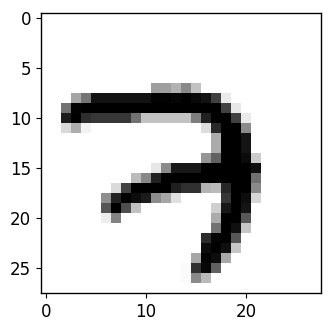

In [3]:
plt.imshow(mnist.train.images[0].reshape(28, 28), cmap='binary')

### Create the graph

In [4]:
tf.reset_default_graph()

In [5]:
n_inputs = 28 * 28
n_units = 14 * 14
n_outputs = n_inputs

In [6]:
X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name="X")
hidden = tf.layers.dense(X, n_units, activation=None, name='undercomplete')
outputs = tf.layers.dense(hidden, n_outputs, activation=None, name='outputs')

In [8]:
reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(reconstruction_loss)

In [10]:
saver = tf.train.Saver()

In [11]:
init = tf.global_variables_initializer()

### Run the graph

In [12]:
batch_size = 200
epochs = 20
codings = hidden

In [13]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, _ = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch})
          if not (epoch % 2): print epoch, reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     save_path = saver.save(sess, '/tmp/data/final.ckpt')

0 0.00822124
2 0.00372771
4 0.00290946
6 0.00282025
8 0.00259283
10 0.00249872
12 0.00254417
14 0.00248637
16 0.0024556
18 0.00247871
20 0.00245194


In [14]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

### Load the saved model and look at some test cases

INFO:tensorflow:Restoring parameters from /tmp/data/final.ckpt


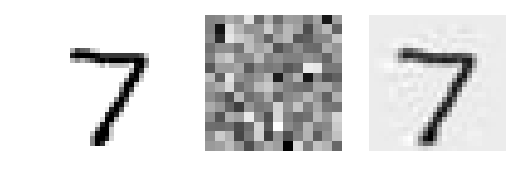

In [15]:
with tf.Session() as sess:
     saver.restore(sess, '/tmp/data/final.ckpt')
     codings_train = codings.eval(feed_dict={X:X_train})
     codings_test = codings.eval(feed_dict={X:X_test})
     outputs_test = outputs.eval(feed_dict={X:X_test})
     
     plt.subplot(131)
     plt.imshow(X_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(132)
     plt.imshow(codings_test[0].reshape(14, 14), cmap='binary'); plt.axis('off')
     plt.subplot(133)
     plt.imshow(outputs_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')

In [28]:
codings_test.shape

(10000, 196)

### Let's look at the weights in the codings layer

In [16]:
[v.name for v in tf.trainable_variables()]

[u'undercomplete/kernel:0',
 u'undercomplete/bias:0',
 u'outputs/kernel:0',
 u'outputs/bias:0']

In [17]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
     init.run()
     saver.restore(sess, '/tmp/data/final.ckpt')
     wts = [v for v in tf.trainable_variables() if v.name == "undercomplete/kernel:0"][0].eval()

INFO:tensorflow:Restoring parameters from /tmp/data/final.ckpt


Each of the 196 neurons in the hidden layer have 784 weights plus a bias.

In [18]:
wts.shape

(784, 196)

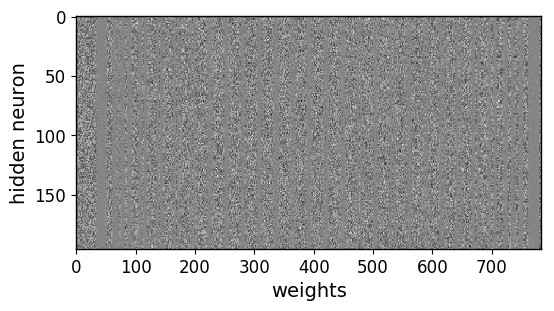

In [19]:
plt.imshow(wts.T, cmap='binary', aspect=2)
plt.xlabel('weights')
plt.ylabel('hidden neuron')

Below we plot the weights for the first three hidden neurons of the 196:

(-0.5, 27.5, 27.5, -0.5)

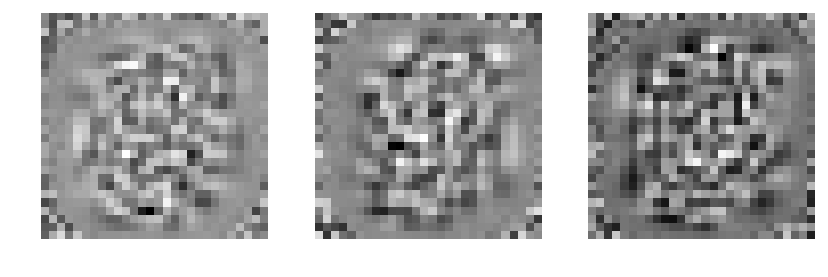

In [20]:
_ = plt.subplots(1, 3, figsize=(10, 3))
plt.subplot(131)
plt.imshow(wts[:,0].reshape(28, 28), cmap='binary'); plt.axis('off')
plt.subplot(132)
plt.imshow(wts[:,1].reshape(28, 28), cmap='binary'); plt.axis('off')
plt.subplot(133)
plt.imshow(wts[:,2].reshape(28, 28), cmap='binary'); plt.axis('off')

### Train simple model using reduced data set

Get the score based on all the training data:

In [21]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(C=10.0).fit(X_train, y_train).score(X_test, y_test)

0.91869999999999996

In [22]:
LogisticRegression(C=0.1).fit(X_train, y_train).score(X_test, y_test)

0.91869999999999996

Get the score based on the codings for three different choices of C:

In [23]:
LogisticRegression(C=10.0).fit(codings_train, y_train).score(codings_test, y_test)

0.92010000000000003

In [24]:
LogisticRegression(C=1.0).fit(codings_train, y_train).score(codings_test, y_test)

0.91869999999999996

In [25]:
LogisticRegression(C=0.1).fit(codings_train, y_train).score(codings_test, y_test)

0.91690000000000005

Since an undercomplete linear autoencoder is just doing PCA, we should get a very similar result to PCA:

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=n_units)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
LogisticRegression(C=1.0).fit(X_train_pca, y_train).score(X_test_pca, y_test)

0.91969999999999996

In [27]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, tol=1e-4, loss='hinge')
sgd_clf.fit(X_train, y_train).score(X_test, y_test)

0.91039999999999999

Recall that we got 97% using a CNN and 98% using a RNN.

### Sklearn MNIST versus Tensorflow MNIST

In [111]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

data, target = load_digits(n_class=10, return_X_y=True)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1437, 64), (1437,), (360, 64), (360,))

In [119]:
LogisticRegression(C=0.01).fit(X_train, y_train).score(X_test, y_test)

0.96666666666666667

In [122]:
sgd_clf = SGDClassifier(random_state=42, tol=1e-4, loss='log')
sgd_clf.fit(X_train, y_train).score(X_test, y_test)

0.94444444444444442

### Now let's try a stacked autoencoder

In [73]:
tf.reset_default_graph()

In [74]:
n_inputs = 28 * 28
n_hidden_1 = 22 * 22
n_hidden_2 = 14 * 14
n_hidden_3 = n_hidden_1
n_outputs = n_inputs

In [75]:
l2_reg = 0.0001

In [78]:
from functools import partial

X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name="input_layer")
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)
hidden1 = my_dense_layer(X, n_hidden_1, name='undercomplete_1')
hidden2 = my_dense_layer(hidden1, n_hidden_2, name='undercomplete_2')
hidden3 = my_dense_layer(hidden2, n_hidden_3, name='undercomplete_3')
outputs = my_dense_layer(hidden3, n_outputs, activation=None, name='output_layer')

In [79]:
reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
total_loss = tf.add_n([reconstruction_loss] + reg_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(total_loss)

In [80]:
saver = tf.train.Saver()

In [81]:
init = tf.global_variables_initializer()

In [82]:
batch_size = 200
epochs = 20
codings = hidden2

In [83]:
ckpt_path = '/tmp/data/final_stacked.ckpt'
with tf.Session() as sess:
     init.run()
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, _ = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch})
          if not (epoch % 2): print epoch, total_loss.eval(feed_dict={X:mnist.validation.images})
     save_path = saver.save(sess, ckpt_path)

0 0.104896
2 0.0351549
4 0.0250581
6 0.0229755
8 0.0224221
10 0.022252
12 0.0221588
14 0.0221682
16 0.0221629
18 0.0221388
20 0.0221035


INFO:tensorflow:Restoring parameters from /tmp/data/final_stacked.ckpt


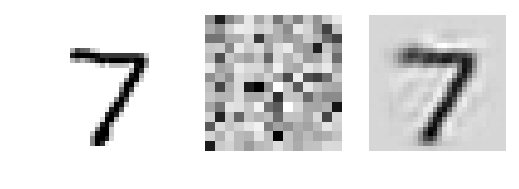

In [84]:
with tf.Session() as sess:
     saver.restore(sess, ckpt_path)
     codings_train = codings.eval(feed_dict={X:X_train})
     codings_test = codings.eval(feed_dict={X:X_test})
     outputs_test = outputs.eval(feed_dict={X:X_test})
     
     plt.subplot(131)
     plt.imshow(X_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(132)
     plt.imshow(codings_test[0].reshape(14, 14), cmap='binary'); plt.axis('off')
     plt.subplot(133)
     plt.imshow(outputs_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')

In [85]:
LogisticRegression(C=1.0).fit(codings_train, y_train).score(codings_test, y_test)

0.91239999999999999

We see that the performance has not improved despite the use of a stacked architecture.

#### Tying weights

One can use the same weights for layers 1 and 3 in the example above. This cuts down of the number of weights which helps to prevent overfitting and speeds up training.